In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib
import scipy.io as scipyio
import matplotlib.pyplot as plt

from tqdm import tqdm

scenario_folder = "/data/DeepSense6G/stationary_scenarios/scenario31"

Fetch scenario CSV and load Dataframe

In [2]:
try:
    csv_file = [f for f in os.listdir(scenario_folder) if f.endswith('csv')][0]
    csv_path = os.path.join(scenario_folder, csv_file)
except:
    raise Exception(f'No csv file inside {scenario_folder}.')

dataframe = pd.read_csv(csv_path)
print(f'Columns: {dataframe.columns.values}')
print(f'Number of Rows: {dataframe.shape[0]}')

Columns: ['index' 'unit1_rgb' 'unit1_pwr_60ghz' 'unit1_lidar' 'unit1_radar'
 'unit1_loc' 'unit2_loc' 'unit1_beam' 'unit1_max_pwr' 'time_stamp'
 'seq_index' 'unit2_spd_over_grnd_kmph' 'unit2_num_sats' 'unit2_altitude'
 'unit2_geo_sep' 'unit2_mode_fix_type' 'unit2_pdop' 'unit2_hdop'
 'unit2_vdop' 'unit2_interpolated_position']
Number of Rows: 7012


mmWave Power Data

In [3]:
N_BEAMS = 64
n_samples = 100
pwr_rel_paths = dataframe['unit1_pwr_60ghz'].values
pwrs_array = np.zeros((n_samples, N_BEAMS))

for sample_idx in tqdm(range(n_samples)):
    pwr_abs_path = os.path.join(scenario_folder, pwr_rel_paths[sample_idx])
    pwrs_array[sample_idx] = np.loadtxt(pwr_abs_path)

100%|██████████| 100/100 [00:00<00:00, 20001.45it/s]


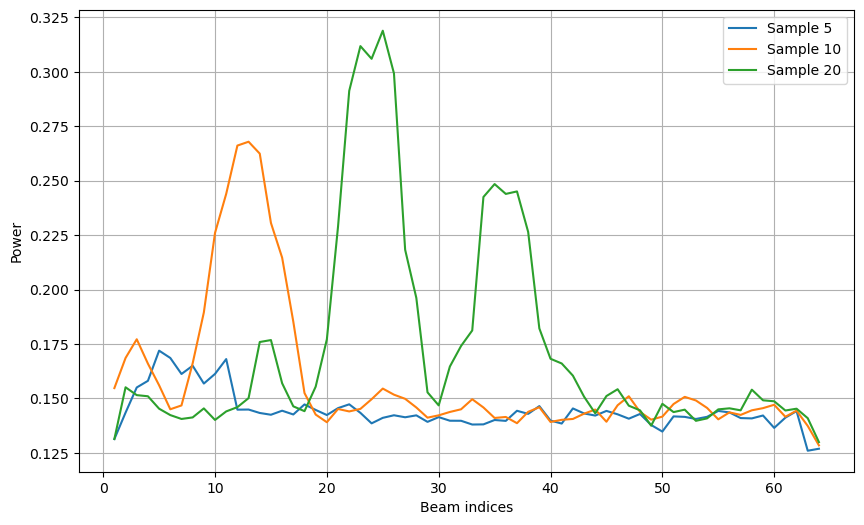

In [4]:
selected_samples = [5, 10, 20]
beam_idxs = np.arange(N_BEAMS) + 1
plt.figure(figsize=(10,6))
plt.plot(beam_idxs, pwrs_array[selected_samples].T)
plt.legend([f'Sample {i}' for i in selected_samples])
plt.xlabel('Beam indices')
plt.ylabel('Power')
plt.grid()

RGB Data

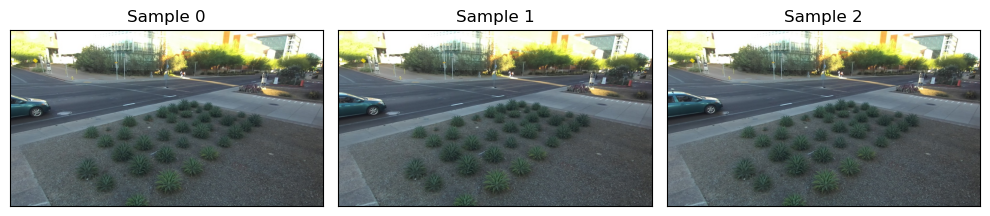

In [5]:
img_rel_paths = dataframe['unit1_rgb'].values
selected_samples = [0,1,2]
fig, axs = plt.subplots(figsize=(10,4), ncols=len(selected_samples), tight_layout=True)
for i, sample_idx in enumerate(selected_samples):
    img_abs_path = os.path.join(scenario_folder, img_rel_paths[sample_idx])
    img = plt.imread(img_abs_path)
    axs[i].imshow(img)
    axs[i].set_title(f'Sample {sample_idx}')
    axs[i].get_yaxis().set_visible(False)
    axs[i].get_xaxis().set_visible(False)

Radar Data

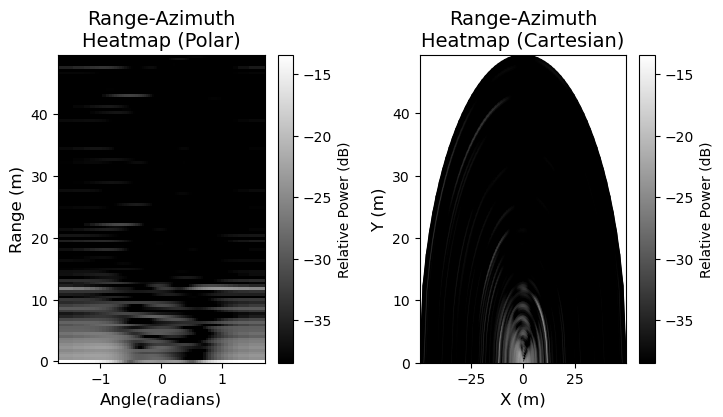

In [13]:
from Radar_Data_Processor import RadarDataProcessor

#initialize the radar
#initialize a raw data processor
radar_data_processor = RadarDataProcessor()
radar_data_processor.set_config_params(
    chirps_per_frame = 250,
    rx_channels = 4,
    tx_channels = 1,
    samples_per_chirp = 256,
    adc_sample_rate_Hz = 6200e3,
    chirp_slope_MHz_us= 8.014,
    start_freq_Hz=77e9,
    idle_time_us = 2,
    ramp_end_time_us = 47.5
)

#get the radar data
sample_idx = 50
radar_rel_paths = dataframe['unit1_radar'].values
#remove ./ from the relative addresses
radar_rel_paths = np.char.replace(radar_rel_paths.astype(str),'./','')
radar_data = np.load(os.path.join(scenario_folder,radar_rel_paths[0]))

#import it into the radar data processor
radar_data_processor.load_frame_from_DeepSense6G(radar_data)

#generate an AoA Heatmap Plot
radar_data_processor.plot_range_azimuth_heatmap(frame=0,chirp=1,cutoff_val_dB = 25,range_lims = [0,50])




Lidar Data

/data/DeepSense6G/stationary_scenarios/scenario31/unit1/lidar_data/lidar_data_323.ply


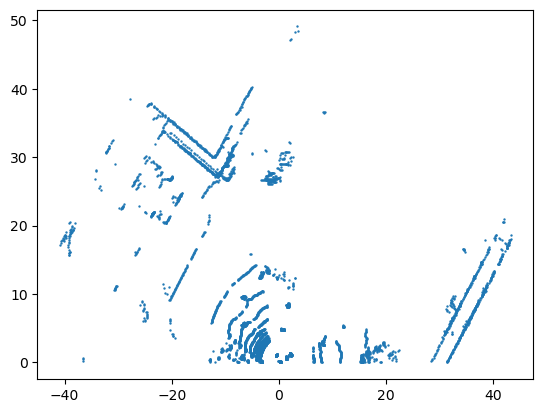

In [11]:
#custom point cloud importation
from Lidar_Data_Processor import LidarDataProcessor

lidar_data_processor = LidarDataProcessor()

#set path to data
lidar_data_processor.load_data_paths(
    scenario_data_path=scenario_folder,
    relative_paths=dataframe["unit1_lidar"].values
)
sample_idx = 150
max_range = 50
angle_range = [0,np.pi]
lidar_data_processor.plot_point_cloud_cartesian(sample_idx,max_range,angle_range)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
/data/DeepSense6G/stationary_scenarios/scenario31/unit1/lidar_data//lidar_data_173.ply


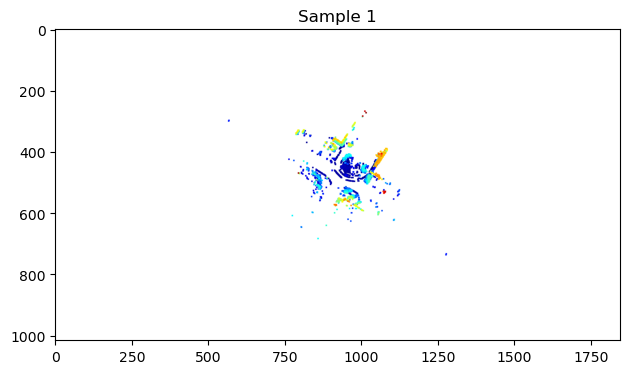

In [7]:
import open3d as o3d
import os
import matplotlib.pyplot as plt
from natsort import natsorted
import numpy as np

# Path to lidar (pointcould) files
lidar_folder_rel_path = "unit1/lidar_data/"
path = os.path.join(scenario_folder,lidar_folder_rel_path)
address = natsorted(os.listdir(path))
outpath = '.'
vis = o3d.visualization.Visualizer()


vis.create_window(visible=True)
vis.poll_events()
vis.update_renderer()
cloud = o3d.io.read_point_cloud(path+"/"+ address[0])
vis.add_geometry(cloud)

# (optional) In case a certain view is desired for the matplotlib shots:
params = {
    "field_of_view" : 60.0,
    "front" : [ -0.01093, 0.0308, 0.9994 ],
    "lookat" : [ -18.9122, -18.4687, 7.3131],
    "up" : [ 0.5496, 0.8351, -0.0197 ],
    "zoom" : 0.3200
    } # These parameters can be copied directly from the visualizer by doing Ctrl+C

opt = vis.get_render_option()
o3d.visualization.ViewControl.set_zoom(vis.get_view_control(), params['zoom'])
o3d.visualization.ViewControl.set_lookat(vis.get_view_control(), params['lookat'])
o3d.visualization.ViewControl.set_front(vis.get_view_control(),params['front'])
o3d.visualization.ViewControl.set_up(vis.get_view_control(), params['up'])


for i in range(1): # number of frames to load
    cloud.points = o3d.io.read_point_cloud(path+"/"+ address[i]).points
    print(path+"/"+ address[i])
    vis.update_geometry(cloud)
    vis.poll_events()
    vis.update_renderer()
    
    ## Plot with matplotlib
    color = np.asarray(vis.capture_screen_float_buffer(True))
    plt.imshow(color)
    plt.title(f'Sample {i+1}')
    plt.savefig(outpath+"/"+ address[i].split('.')[0] + '.png', dpi=300)
    plt.tight_layout()
    plt.pause(0.1)
vis.destroy_window()